## cell type colocalization heatmap
<br>
<b>Description</b> : In this notebook we are using the Tangram2 mapping result to plot the colocalization relationship between cell types for TNBC and ER+ breast cancer.<br>
<b>Author</b> : Hejin Huang (huang.hejin@gene.com)<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.stats import pearsonr

/raid/home/huangh83/miniforge3/envs/tangram2/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# Define patient IDs and groups
patient_ID = ['CID4290', 'CID4535', 'CID4465', 'CID44971', '1142243F', '1160920F']
TNBC = ['CID4465', 'CID44971', '1142243F', '1160920F']
ER = ['CID4290', 'CID4535']

# Load mapped AnnData objects for all patients
ad_map_all = []
for patient_id in patient_ID:
    ad_map = sc.read_h5ad(f'../../data/imod/bc/mapping_result/{patient_id}.h5ad')
    ad_map_all.append(ad_map)

/tmp/ipykernel_3088964/620634786.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_cells[patient_id] = ad_map.obs.groupby('celltype_major')['coefficient'].sum().reindex(ordered_major_celltypes, fill_value=0)
/tmp/ipykernel_3088964/620634786.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_cells[patient_id] = ad_map.obs.groupby('celltype_major')['coefficient'].sum().reindex(ordered_major_celltypes, fill_value=0)
/tmp/ipykernel_3088964/620634786.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

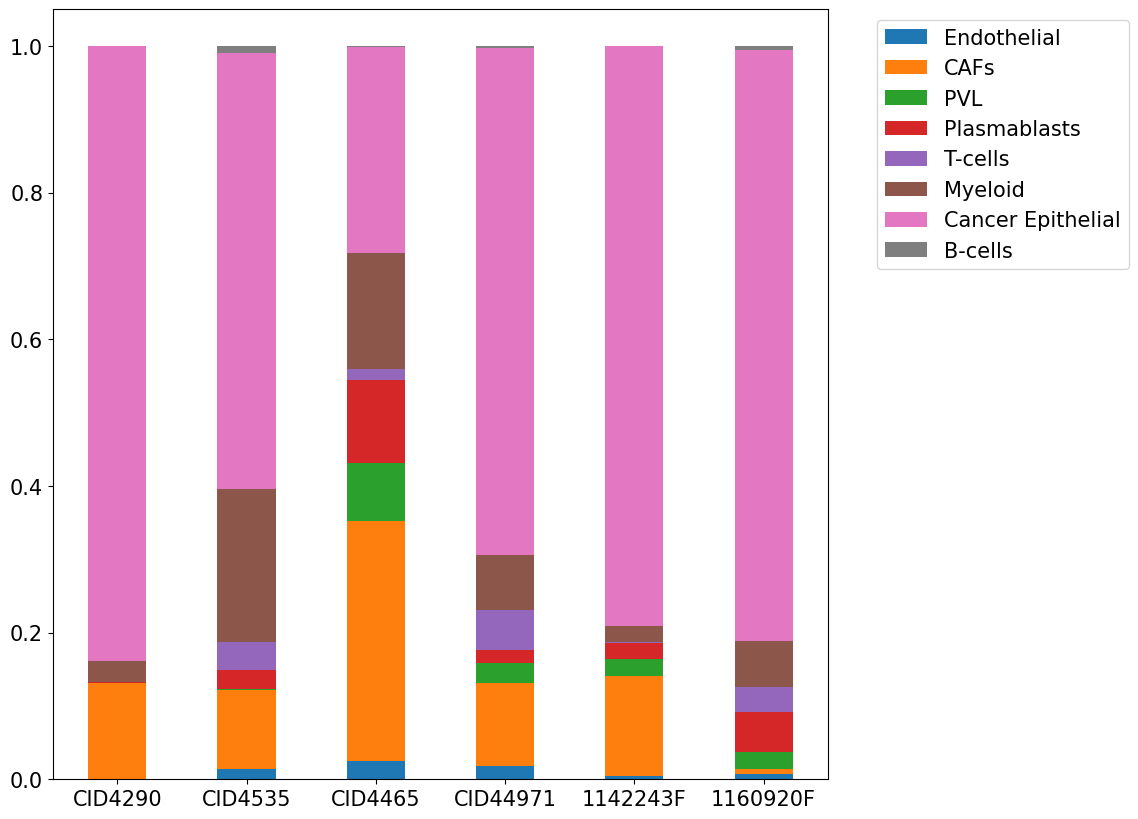

In [3]:
# Calculate total 'coefficient' per major cell type for each patient
ordered_major_celltypes = ad_map_all[0].obs['celltype_major'].unique()
all_cells = pd.DataFrame(index=ordered_major_celltypes)

for i, patient_id in enumerate(patient_ID):
    ad_map = ad_map_all[i]
    all_cells[patient_id] = ad_map.obs.groupby('celltype_major')['coefficient'].sum().reindex(ordered_major_celltypes, fill_value=0)

# Generate and display a stacked bar chart of cell type proportions
colors = list(sns.color_palette("tab10"))
for i in range(len(sns.color_palette("tab20"))):
    if i % 2 == 1:
        colors.append(sns.color_palette("tab20")[i])

xaxis = patient_ID
fig, ax = plt.subplots(figsize=(10, 10))
bottom = np.zeros(len(xaxis))  # Initialize bottom array with zeros
color_idx = 0

for annot in all_cells.index:
    means = all_cells.loc[annot].values  # Get values as numpy array for vectorized addition
    ax.bar(xaxis, means, width=0.45, label=annot,
           bottom=bottom, color=colors[color_idx])
    bottom += means  # Update bottom for the next stack
    ax.legend(bbox_to_anchor=(1.05, 1.0), fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    color_idx += 1
plt.show()

In [4]:
# Prepare data for Pearson correlation calculation based on 'celltype_minor'
cell_type_annotation = 'celltype_minor'

# Initialize lists to store combined dataframes for ER and TNBC patients
ER_combined_dfs = []
TNBC_combined_dfs = []

for i in range(len(ad_map_all)):
    ad_map = ad_map_all[i]
    cell_subtype_list = sorted(list(ad_map.obs[cell_type_annotation].unique()))

    # Create a DataFrame for the current patient's combined data
    combined_data_df = pd.DataFrame(
        np.zeros((len(cell_subtype_list), ad_map.shape[1])),
        index=cell_subtype_list,
        columns=ad_map.var_names
    )

    for j, subtype in enumerate(cell_subtype_list):
        # Sum expression for each cell subtype
        combined_data_df.loc[subtype] = ad_map[ad_map.obs[cell_type_annotation] == subtype].X.sum(axis=0)

    # Handle very small sums: if sum is less than 0.0005, negate the row.
    # This part of the original logic seems unusual for typical expression data but is retained.
    small_sum_mask = combined_data_df.sum(axis=1) < 0.0005
    combined_data_df.loc[small_sum_mask] = -combined_data_df.loc[small_sum_mask]

    if patient_ID[i] in ER:
        ER_combined_dfs.append(combined_data_df)
    elif patient_ID[i] in TNBC:
        TNBC_combined_dfs.append(combined_data_df)

# Concatenate along axis=1 (genes) to create final ER and TNBC dataframes
ER_df = pd.concat(ER_combined_dfs, axis=1)
TNBC_df = pd.concat(TNBC_combined_dfs, axis=1)

In [5]:
# Calculate Pearson correlation matrices
def calculate_pearson_correlation(dataframe):
    num_subtypes = len(dataframe)
    pearson_matrix = np.zeros((num_subtypes, num_subtypes))

    for i in range(num_subtypes):
        for j in range(num_subtypes):
            # Identify elements where both series are positive
            positive_mask = (dataframe.iloc[i] > 0) & (dataframe.iloc[j] > 0)

            if positive_mask.sum() > 0:
                # Calculate Pearson correlation only on positive values
                pearson_matrix[i, j], _ = pearsonr(dataframe.iloc[i][positive_mask], dataframe.iloc[j][positive_mask])
            else:
                # If no common positive values, calculate on absolute values (as per original logic)
                pearson_matrix[i, j], _ = pearsonr(abs(dataframe.iloc[i]), abs(dataframe.iloc[j]))
    return pd.DataFrame(data=pearson_matrix, index=dataframe.index, columns=dataframe.index)



In [9]:
pearson_ER = calculate_pearson_correlation(ER_df)
pearson_TNBC = calculate_pearson_correlation(TNBC_df)

# Determine cell types with a 'coefficient' sum > 0.0005 across patients
large_ER_proportion = []
large_TNBC_proportion = []

# Iterate through patient_ID and ad_map_all simultaneously
for pat_id, ad_map in zip(patient_ID, ad_map_all):
    if pat_id in ER:
        for j in pearson_ER.index:
            if j not in large_ER_proportion and ad_map[ad_map.obs.celltype_minor == j].obs['coefficient'].sum() > 0.0005:
                large_ER_proportion.append(j)
    elif pat_id in TNBC:
        for j in pearson_TNBC.index:
            if j not in large_TNBC_proportion and ad_map[ad_map.obs.celltype_minor == j].obs['coefficient'].sum() > 0.0005:
                large_TNBC_proportion.append(j)


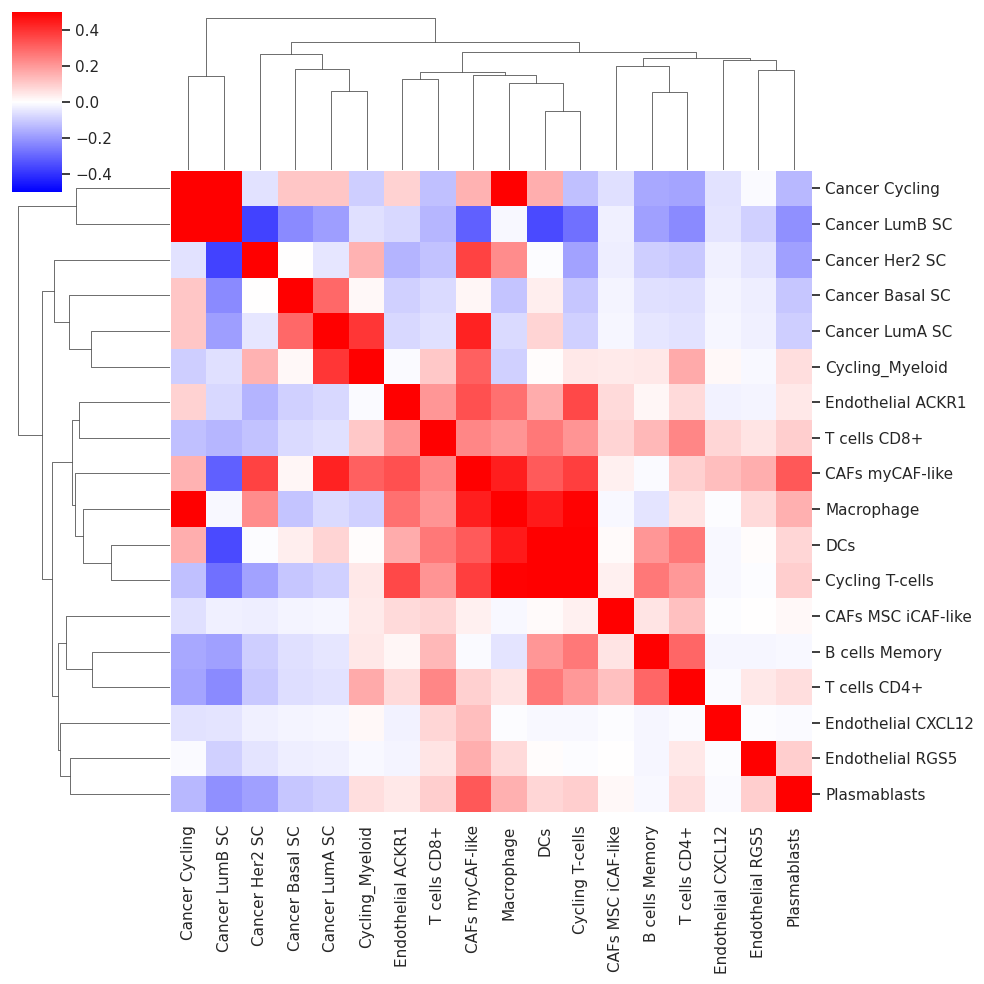

In [10]:
# Generate and display clustermaps
sns.set(rc={'figure.figsize': (20, 4)}, font_scale=1.0)
g = sns.clustermap(pearson_ER.loc[large_ER_proportion, large_ER_proportion],
                   annot=False, fmt='d', cmap='bwr', xticklabels=True, yticklabels=True, vmin=-0.5, vmax=0.5)
plt.show()

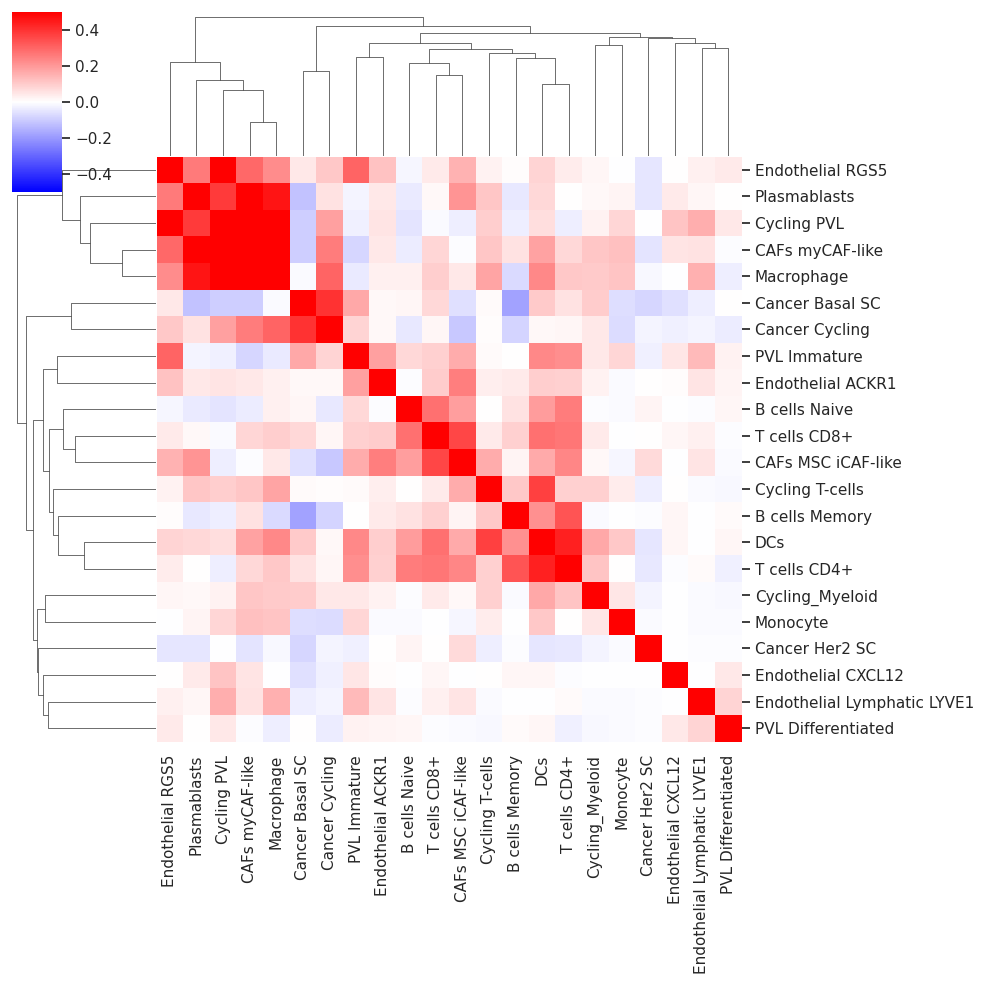

In [11]:
sns.set(rc={'figure.figsize': (20, 4)}, font_scale=1.0)
g = sns.clustermap(pearson_TNBC.loc[large_TNBC_proportion, large_TNBC_proportion],
                   annot=False, fmt='d', cmap='bwr', xticklabels=True, yticklabels=True, vmin=-0.5, vmax=0.5)
plt.show()